In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import random

# Data Loading

In [44]:
train = pd.read_csv('data/lab2_train.csv', delimiter = ',')
test = pd.read_csv('data/lab2_test.csv', delimiter = ',')

# Familiarization

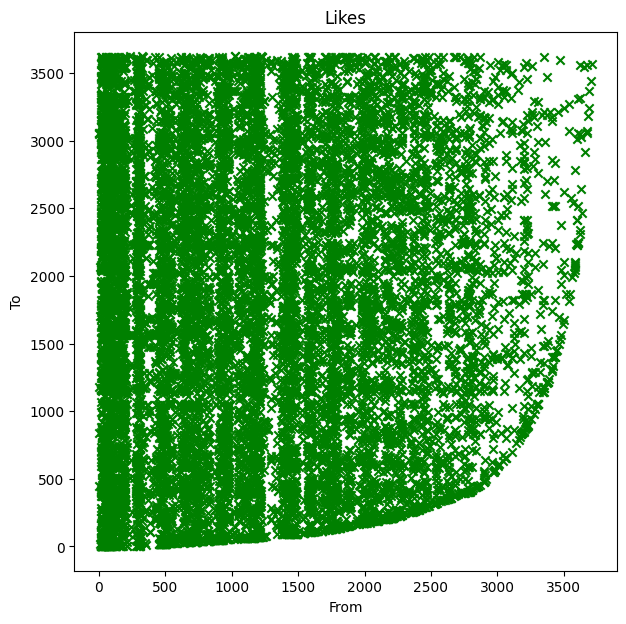

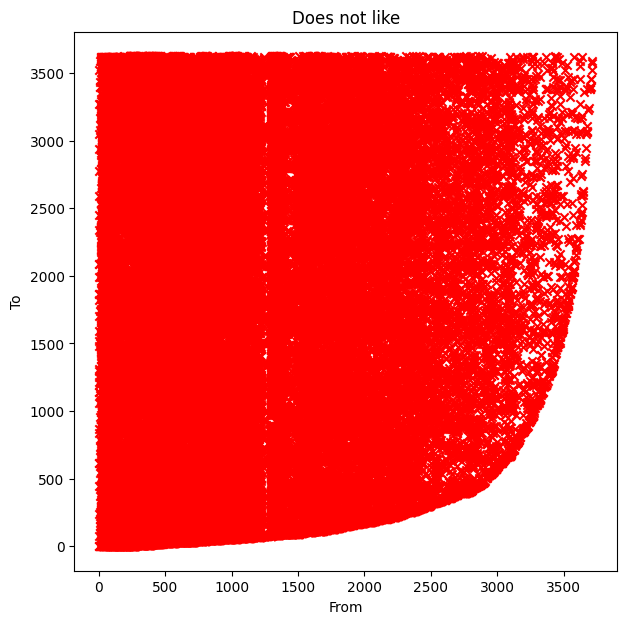

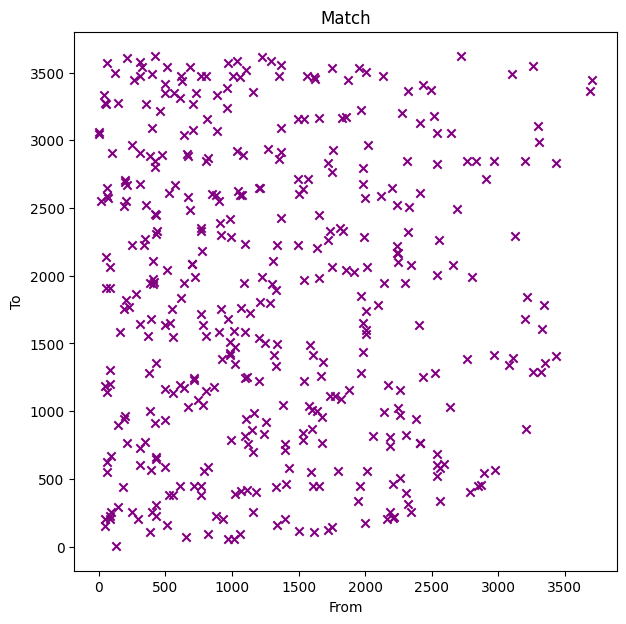

In [45]:
true = train[train['is_like']]
false = train[train['is_like'] == False]
match = train[train['is_match'] == True]

plt.figure(figsize=(7, 7))
plt.scatter(true['user_from_id'], true['user_to_id'], color = 'green', marker = 'x')
plt.title('Likes')
plt.xlabel('From')
plt.ylabel('To')
plt.show()

plt.figure(figsize=(7, 7))
plt.scatter(false['user_from_id'], false['user_to_id'], color = 'red', marker = 'x')
plt.title('Does not like')
plt.xlabel('From')
plt.ylabel('To')
plt.show()

plt.figure(figsize=(7, 7))
plt.scatter(match['user_from_id'], match['user_to_id'], color = 'purple', marker = 'x')
plt.title('Match')
plt.xlabel('From')
plt.ylabel('To')
plt.show()

It can clearly be seen that there are more dislikes than dislikes, and that matches are extremely rare.

Moreover, there is also fewer data for users with high ids, as they have probably been using the platform for less time. Some groups of users such as those with users between 1200-1400 have had very little activity, and those with the highest ids have had little to no interaction with those with lower ids (gender?).



In [46]:
len(true)/len(train) * 100

16.54230809508849

As only 17% of the data are likes it is clear that the matrix representing which users like which will be very sparse.

# Non-negative Matrix Factorization

# Distance-based recommending

The following cells show the code implemented on WebLab.
Note I added a function to generate a random list of hash functions.

In [47]:
class HashFunction:
    """
    This HashFunction class can be used to create an unique hash given an alpha and beta.
    """
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta

    def hashf(self, x, n):
        """
        Returns a hash given integers x and n.
        :param x: The value to be hashed
        :param n: The number of unique ids of all sets
        :return: The hashed value x given alpha and beta
        """

        hash_value = 0
        hash_value =  (self.alpha * x + self.beta) % n
        return hash_value

    def generate_hash_functions(l):
        """
        Generate a list of l unique HashFunction instances.
        :param l: Number of hash functions to generate
        :return: List of HashFunction instances
        """
        hash_functions = []

        for i in range(l):
            alpha = random.randint(0, 2**i+2 - 1)
            beta = random.randint(0, 2**i+2 - 1)
            hash_function = HashFunction(alpha, beta)
            hash_functions.append(hash_function)

        return hash_functions

In [48]:
def compute_signature(hashes: list[HashFunction], ids: list[set[int]]):
    """
    This function will calculate the MinHash signature matrix from our sets of ids
    using the list of hash functions (hashes)
    :param hashes: The list of hash functions of arbitrary length
    :param ids: The list of sets of ids
    :return: The MinHash signature matrix for the given sets of ids
    """

    result = np.full((len(hashes), len(ids)), sys.maxsize, dtype=np.uint32)

    space = set().union(*ids)
    sorted_space = sorted(space)

    binary_matrix = np.zeros((len(sorted_space), len(ids)), dtype=int)

    for colIndex, user_likes in enumerate(ids):
        for rowIndex, unique_id in enumerate(sorted_space):
            if unique_id in user_likes:
                binary_matrix[rowIndex, colIndex] = 1

    # START ANSWER
    for rowIndex in range(len(sorted_space)):
        hashedValues = []
        for hashIndex in range(len(hashes)):
            hashed = hashes[hashIndex].hashf(rowIndex, len(sorted_space))
            hashedValues.append(hashed)
        for colIndex in range(len(ids)):
            if binary_matrix[rowIndex, colIndex]:
                for hashIndex2 in range(len(hashes)):
                    result[hashIndex2, colIndex] = min(hashedValues[hashIndex2], result[hashIndex2, colIndex])
    # END ANSWER

    return result

Now that we have this code, we can generate the list of sets used by the code on WebLab.

In [49]:
unique_ids = train['user_from_id'].max()
id_set = [set() for _ in range(unique_ids + 1)]
for index, row in train.iterrows():
    id_set[row['user_from_id']].add(row['user_to_id'])

We will calculate signature matrices for a different number of hash functions.
We will try with 30, 60, 80 and 110 different hashes.

In [50]:
signature_80 = compute_signature(HashFunction.generate_hash_functions(80), id_set)
signature_110 = compute_signature(HashFunction.generate_hash_functions(110), id_set)
signature_140 = compute_signature(HashFunction.generate_hash_functions(140), id_set)

We will now compute the Jaccard similarity between columns to get the top-k results.

In [51]:
def jaccard(k, signature):
    distances = []
    for outerIndex in range(signature.shape[1]):
        for innerIndex in range(signature.shape[1]):
            if innerIndex == outerIndex:
                continue
            outerArr = signature[:, outerIndex]
            innerArr = signature[:, innerIndex]
            intersection_size = len(np.intersect1d(outerArr, innerArr))
            union_size = len(np.union1d(outerArr, innerArr))
            distance = (outerIndex, innerIndex, float(intersection_size) / float(union_size))
            distances.append(distance)
    sortedDistances = sorted(distances, key = lambda x: x[2], reverse = True)
    return sortedDistances[:k]

Due to the fact that in the train set, there are only around 17% of likes, we will return the top 15% of similar columns. To maintain the same ratio of likes to don't like in the test set.

In [ ]:
k = int(0.15 * train.shape[0])
similar80 = jaccard(k, signature_80)
similar110 = jaccard(k, signature_110)
similar140 = jaccard(k, signature_140)

We now define a function to predict data for the test set.

In [ ]:
def predict(similar):
    predictions = []
    for row in test.iterrows():
        data = row[1]
        from_id = data['user_from_id']
        to_id = data['user_to_id']
        inSimilar = False
        for data in similar:
            if data[0] == from_id & data[1] == to_id:
                inSimilar = True
                break
        predictions.append(inSimilar)
    return predictions

In [ ]:
predictions80 = predict(similar80)
predictions110 = predict(similar110)
predictions140 = predict(similar140)

Let's convert predictions to Pandas DataFrames in order to get .csv files.

In [ ]:
pd.DataFrame(predictions80, columns = 'is_like').to_csv()
pd.DataFrame(predictions110, columns = 'is_like').to_csv()
pd.DataFrame(predictions140, columns = 'is_like').to_csv()